# Assignment 3  - Part C


#### Roll Number:20030012


### Task Explanation

In this task, we will perform feature extraction and fine-tuning on a previously trained over a large dataset model. This is a very useful domain of Deep Learning known as Transfer Learning. We don't always have the luxury of time and computational power to adequately train a large model over our dataset. So, we use models which have been trained on large datasets (usually ImageNet) and then fine-tune them on our dataset. The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

Here, we will fine-tune a previously trained model on imagenet to learn and classify three new class: Richshaw, qingqi and Tanga. 


### Dataset



The dataset is divided into training set and testing set. The training set is labeled and contains 80 images for each class (Total 240 images). You have been given unlabeled test set and your task is to predict the class of each test image. The test set contain 853 images.<br>
Some guidelines:<br>
- You are free to extend or augment the training set.<br>
- If you want, you can use a subset of training set as your validation set.<br>
- You must not use the provided test set in any way except for final predictions.<br>

In [ ]:
!git clone https://github.com/MMFa666/VehicleDataset.git

Cloning into 'VehicleDataset'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (1106/1106), done.
remote: Compressing objects: 100% (1100/1100), done.
remote: Total 1106 (delta 4), reused 1103 (delta 4), pack-reused 0
Receiving objects: 100% (1106/1106), 34.18 MiB | 29.17 MiB/s, done.
Resolving deltas: 100% (4/4), done.


### Models


You can use anyone of the following models for this task. See the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications#functions) for more details.
- VGG
- ResNet
- MobileNet
- EfficientNet

### LeaderBoard

The goal here is to get the maximum performance on test set. For this purpose, we have created a competition on Kaggle where a leaderboard is maintained. You will upload your predictions for test set there and a score will be generated for you. You will be ranked based on your score. You can submit upto 20 times a day with maximum 300 submissions in total.

This part will be evaluated based on your approach and your performance in LeaderBoard. Furthermore, the top student will receive a 5%, 2nd will receive 3% and 3rd will receive 1% bonus.

You are allowed to the following to win:
- Extend your chosen model as you like.
- Extend the training set.
- Augment the training set.
- Play with hyperparameters.
- Preprocess the data as you like.

Competition link [here](https://www.kaggle.com/c/lums-cs437-hw3/)

### Tutuorial Example

You are recommended to follow this [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning) for this task. All the hints and information required are available here and this task can be easily completed by following it. In this tutorial, they use MobileNet but as mentioned above you are free to use any of the abovementioned models.

### Let The Games Begin!!!

In [ ]:
# make necessary imports here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import random

from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, LeakyReLU, Flatten, Dropout, GlobalAveragePooling2D, experimental,MaxPooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix
import seaborn as sns
# any other imports that you may require
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Sequential
from tensorflow import expand_dims
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import mobilenet_v2, MobileNetV2
from tensorflow.image import convert_image_dtype
from tensorflow import float16
import csv

In [ ]:
labels={}
labels['qingqi']=[1,0,0]
labels['rickshaw']=[0,1,0]
labels['tanga']=[0,0,1]

In [ ]:
# define hyperparameters

epochs = 30 
learning_rate = 0.001 
batch_size = 30
input_shape = (160, 160, 3)
img_size = (160,160)

In [ ]:
## augmenting the data set
!rm -rf VehicleDataset/  ## clear directory first
!git clone https://github.com/MMFa666/VehicleDataset.git ## clone dataset

## now augment training set
data_augmentation = Sequential([
  experimental.preprocessing.RandomFlip('horizontal'),
  experimental.preprocessing.RandomRotation(0.2),
])

for dataset_folder in glob.glob('/content/VehicleDataset/train*'):
  for type_folder in glob.glob(dataset_folder + '/*'):
    for img_link in glob.glob(type_folder+'/*'):
      img_name = img_link.split('/')[-1].split('.')[0] 
      img = cv2.imread(img_link)
      img.resize((input_shape))
      for k in range(1): ## for each img generate 1 versions rotated for train set
        augmented_image = data_augmentation(expand_dims(img, 0))
        cv2.imwrite(os.path.join(type_folder, img_name+'__'+str(k)+'_.jpg'), np.array(augmented_image[0]))
        



Cloning into 'VehicleDataset'...
remote: Enumerating objects: 1106, done.
remote: Counting objects: 100% (1106/1106), done.
remote: Compressing objects: 100% (1100/1100), done.
remote: Total 1106 (delta 4), reused 1103 (delta 4), pack-reused 0
Receiving objects: 100% (1106/1106), 34.18 MiB | 26.57 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
# read and preprocess the training data and extract the labels. (If your training data is large then you can also use batch generator like done in PartB.)
# print the shape x and y data
# split into validation set if you desire


train_dir = '/content/VehicleDataset/train/'
test_dir = '/content/VehicleDataset/test/'

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=batch_size,
                                             image_size=img_size,
                                             label_mode = 'categorical')





Found 480 files belonging to 3 classes.


### Feature Extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

In [ ]:
# intialize the base model here and print the model summary
base_model = MobileNetV2(input_shape=input_shape,
                         include_top=False,
                         weights='imagenet')

base_model.summary()

global_average_layer = GlobalAveragePooling2D()
preprocess_input = mobilenet_v2.preprocess_input





Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_26[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 

In [ ]:
# Freeze the base Model
base_model.trainable = False


In [ ]:
# Add your desired classification head and initalize new model
inputs = Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = Dropout(0.2)(x)
prediction_layer = Dense(3,activation='softmax') 
outputs = prediction_layer(x)
model = Model(inputs, outputs)


In [ ]:
# compile the model and print the summary
model.compile(
    loss=CategoricalCrossentropy(from_logits=False),
    optimizer=Adam(learning_rate= learning_rate),
    metrics=["accuracy"],
)
model.summary()


Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_14 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_14 (TFOpLam (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0  

In [ ]:
# fit the model
hist = model.fit(train_dataset, epochs= epochs)


Epoch 1/30
16/16 [==============================] - 4s 46ms/step - loss: 1.5397 - accuracy: 0.3588
Epoch 2/30
16/16 [==============================] - 1s 41ms/step - loss: 1.0855 - accuracy: 0.5113
Epoch 3/30
16/16 [==============================] - 1s 40ms/step - loss: 0.9747 - accuracy: 0.5907
Epoch 4/30
16/16 [==============================] - 1s 42ms/step - loss: 0.8550 - accuracy: 0.6156
Epoch 5/30
16/16 [==============================] - 1s 40ms/step - loss: 0.6647 - accuracy: 0.7209
Epoch 6/30
16/16 [==============================] - 1s 39ms/step - loss: 0.7158 - accuracy: 0.6665
Epoch 7/30
16/16 [==============================] - 1s 40ms/step - loss: 0.5872 - accuracy: 0.7458
Epoch 8/30
16/16 [==============================] - 1s 39ms/step - loss: 0.5904 - accuracy: 0.7159
Epoch 9/30
16/16 [==============================] - 1s 40ms/step - loss: 0.5746 - accuracy: 0.7457
Epoch 10/30
16/16 [==============================] - 1s 40ms/step - loss: 0.5872 - accuracy: 0.7280
Epoch 11/

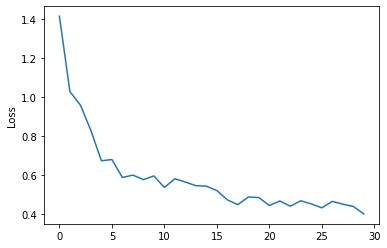

In [ ]:
# plot the loss and accuracy curves

loss = hist.history['loss']
plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.show()

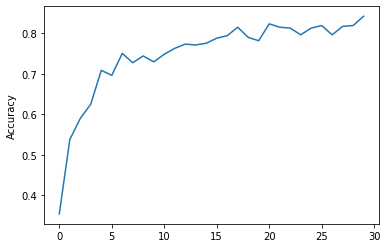

In [ ]:
acc = hist.history['accuracy']
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.show()

### Fine Tuning

In the feature extraction, you were only training a few layers on top of a base model. The weights of the pre-trained network were not updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [ ]:
# unfreeze the base model
base_model.trainable = True


In [ ]:
# print the number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))


Number of layers in the base model:  154


You should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [ ]:
# Decide the number of layers you want to freeze and freeze them.
fine_tune_at = 80
for layer in base_model.layers[:fine_tune_at]:  ## freezing layers
  layer.trainable =  False


In [ ]:
# compile the model again.
# It is advisable to use a lower learning rate here so that updates are not too huge and the model does not overfit.
# print model summary

model.compile(loss=CategoricalCrossentropy(from_logits=False),
              optimizer = RMSprop(lr=learning_rate/10),
              metrics=['accuracy'])


model.summary()



Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_14 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_14 (TFOpLam (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_11  (None, 1280)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 1280)              0  

In [ ]:
# fit the model again.
fine_tune_epochs = 30
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=hist.epoch[-1],
                         )



Epoch 30/60
16/16 [==============================] - 6s 60ms/step - loss: 0.7342 - accuracy: 0.7590
Epoch 31/60
16/16 [==============================] - 1s 56ms/step - loss: 0.3647 - accuracy: 0.8440
Epoch 32/60
16/16 [==============================] - 1s 56ms/step - loss: 0.3762 - accuracy: 0.8351
Epoch 33/60
16/16 [==============================] - 1s 57ms/step - loss: 0.3323 - accuracy: 0.8650
Epoch 34/60
16/16 [==============================] - 1s 58ms/step - loss: 0.4338 - accuracy: 0.8237
Epoch 35/60
16/16 [==============================] - 1s 55ms/step - loss: 0.3003 - accuracy: 0.8773
Epoch 36/60
16/16 [==============================] - 1s 57ms/step - loss: 0.4408 - accuracy: 0.8330
Epoch 37/60
16/16 [==============================] - 1s 57ms/step - loss: 0.2974 - accuracy: 0.8697
Epoch 38/60
16/16 [==============================] - 1s 56ms/step - loss: 0.2745 - accuracy: 0.8865
Epoch 39/60
16/16 [==============================] - 1s 56ms/step - loss: 0.2746 - accuracy: 0.9036


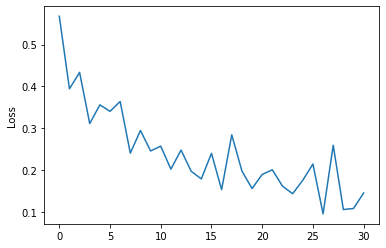

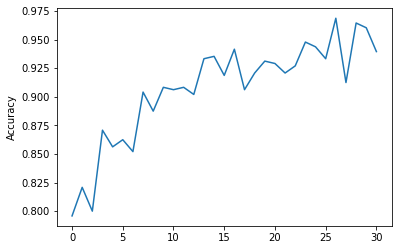

In [ ]:
# plot the loss and accuracy curves again
loss = history_fine.history['loss']
plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.show()

acc = history_fine.history['accuracy']
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.show()





### Prediction

Now we will use our model to make predictions on test set. Store the predictions like in sample_submission.csv file. 

sample_submission.csv
- 4 columns
- 1 row for each test image (total 853 rows)
- 1st column = image file name
- 2nd column = probability of the given image being qingqi
- 3rd column = probability of the given image being rickshaw
- 4th column = probability of the given image being tanga

In [ ]:
def preprocessing_norm(images):
    return (images/127.5)-1  ## range pixels between -1 to 1

In [ ]:
# Read and preprocess test data. Remeber to store the names of image files
test_X = []
img_file_names = []
for file_path in glob.glob('/content/VehicleDataset/test/*'):
  img = preprocessing_norm(cv2.imread(file_path))
  img.resize((input_shape))
  test_X.append(img)
  img_file_names.append(file_path.split('/')[-1].split('.')[0])


In [ ]:
# predict on test data (Hint: model.predict())
preds = model.predict(np.array(test_X))

In [ ]:
result_csv= 0

In [ ]:
# store the predictions in a .csv file like in sample_submission.csv (Hint: pandas may be helpful here)

result_csv+=1
data = [['id', 'qingqi', 'rickshaw', 'tanga']]

for index, pred in enumerate(preds):
  file_name = img_file_names[index]
  probabilites = list(pred)
  probabilites.insert(0,file_name)
  data.append(probabilites)

data = np.array(data)
df = pd.DataFrame(data=data[1:,0:],
                  columns= data[0,0:])
df.to_csv('result'+str(result_csv)+'.csv', index=False)
